In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

from scipy.stats import poisson
from tqdm import tqdm

In [2]:
##data from https://www.advancedsportsanalytics.com/nfl-raw-data
import os
os.chdir('/Users/allisonkruse/desktop/nfl')
os.getcwd()

'/Users/allisonkruse/Desktop/nfl'

In [3]:
path = '/Users/allisonkruse/desktop/nfl/nfl_pass_rush_receive_raw_data.csv'
#path = '/Users/allisonkruse/desktop/nfl/nfl_pass_rush_receive_raw_data'
df = pd.read_csv(path)
pdp = pd.DataFrame(df)
pdp = pdp[pdp['pos'] == 'QB']
pdp.head()

,game_id,player_id,pos,player,team,pass_cmp,pass_att,pass_yds,pass_td,pass_int,...,Surface,Temperature,Humidity,Wind_Speed,Vegas_Line,Vegas_Favorite,Over_Under,game_date,game_year,season
0,202009100kan,WatsDe00,QB,Deshaun Watson,HOU,20,32,253,1,1,...,astroturf,56,95,7,-9.5,KAN,53.5,9/10/20,2020,2020
10,202009100kan,MahoPa00,QB,Patrick Mahomes,KAN,24,32,211,3,0,...,astroturf,56,95,7,-9.5,KAN,53.5,9/10/20,2020,2020
22,202009130atl,WilsRu00,QB,Russell Wilson,SEA,31,35,322,4,0,...,fieldturf,72,45,0,-1.0,ATL,49.5,9/13/20,2020,2020
25,202009130atl,RyanMa00,QB,Matt Ryan,ATL,37,54,450,2,1,...,fieldturf,72,45,0,-1.0,ATL,49.5,9/13/20,2020,2020
52,202009130buf,DarnSa00,QB,Sam Darnold,NYJ,21,35,215,1,1,...,astroturf,67,93,15,-6.5,BUF,39.5,9/13/20,2020,2020


In [5]:
#filter down to columns we need, filter to just 2022 season 
qb = pdp[['game_id','player_id','player','pass_td','season']] 
qb = qb[qb['season'] == 2022]
qb_gb = qb.groupby(['game_id','player'])['pass_td'].sum().reset_index()
qb_gb.sort_values(by=['pass_td'],ascending=False)

,game_id,player,pass_td
64,202209180rav,Tua Tagovailoa,6
12,202209110crd,Patrick Mahomes,5
361,202211200pit,Joe Burrow,4
510,202212180tam,Joe Burrow,4
47,202209180det,Jared Goff,4
...,...,...,...
82,202209250crd,Kyler Murray,0
352,202211200min,Kirk Cousins,0
353,202211200min,Nick Mullens,0
355,202211200nor,Bryce Perkins,0


In [6]:
#mean touchdowns per game 2020-2022
qb_gb_2022 = qb.groupby(['player'])['pass_td'].mean().reset_index()
qb_gb_2022.sort_values(by=['pass_td'],ascending=False)

,player,pass_td
59,Patrick Mahomes,2.466667
34,Joe Burrow,2.266667
38,Josh Allen,2.133333
18,Dak Prescott,2.000000
73,Tua Tagovailoa,1.923077
...,...,...
10,C.J. Beathard,0.000000
12,Case Keenum,0.000000
57,Nick Mullens,0.000000
56,Nick Foles,0.000000


In [7]:
qb_proj = qb_gb_2022

qb_proj = qb_proj.sort_values(by=['pass_td'],ascending=False)

qb_proj = qb_proj.reset_index(drop=True)

# theta = mu/0.22
# k = mu * theta

qb_proj['rate'] = qb_proj['pass_td'].copy()/0.22
qb_proj['shape_'] = qb_proj['rate'].copy() * qb_proj['pass_td'].copy()

qb_proj['qb_i'] = qb_proj.index

qb_proj

,player,pass_td,rate,shape_,qb_i
0,Patrick Mahomes,2.466667,11.212121,27.656566,0
1,Joe Burrow,2.266667,10.303030,23.353535,1
2,Josh Allen,2.133333,9.696970,20.686869,2
3,Dak Prescott,2.000000,9.090909,18.181818,3
4,Tua Tagovailoa,1.923077,8.741259,16.810113,4
...,...,...,...,...,...
72,C.J. Beathard,0.000000,0.000000,0.000000,72
73,Case Keenum,0.000000,0.000000,0.000000,73
74,Nick Mullens,0.000000,0.000000,0.000000,74
75,Nick Foles,0.000000,0.000000,0.000000,75


In [8]:
#do same thing for defenses 
dfn_all_season = pdp[['game_id','Opponent_abbrev','pass_td','season','pos']] #how many touchdowns did the opposing team allow 
dfn= dfn_all_season[dfn_all_season['season'] == 2022]

dfn.head()

,game_id,Opponent_abbrev,pass_td,season,pos
13643,202209080ram,LAR,3,2022,QB
13652,202209080ram,BUF,1,2022,QB
13665,202209110atl,ATL,2,2022,QB
13666,202209110atl,ATL,0,2022,QB
13670,202209110atl,NOR,0,2022,QB


In [9]:
dfn.rename(columns = {'Opponent_abbrev':'def_team'}, inplace = True)
dfn_gb = dfn.groupby(['game_id','def_team'])['pass_td'].sum().reset_index()
dfn_gb.sort_values(by=['pass_td'],ascending=False)

/var/folders/fm/q_6bgl_x59q7p7h8ld62qh600000gn/T/ipykernel_12157/4138725583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn.rename(columns = {'Opponent_abbrev':'def_team'}, inplace = True)


,game_id,def_team,pass_td
56,202209180rav,BAL,6
10,202209110crd,ARI,5
467,202212240sfo,SFO,5
238,202210300phi,PIT,4
61,202209190buf,TEN,4
...,...,...,...
356,202211280clt,IND,0
149,202210090nyj,NYJ,0
353,202211270sfo,SFO,0
151,202210090ram,LAR,0


In [10]:
dfn_gb_full_season = dfn.groupby(['def_team'])['pass_td'].sum().reset_index()
dfn_gb_full_season.sort_values(by=['pass_td'],ascending=False)

,def_team,pass_td
18,KAN,31
0,ARI,26
29,PIT,25
22,MIA,25
11,DET,24
33,TEN,24
32,TAM,24
17,JAX,24
25,NWE,23
9,DAL,23


In [11]:
dfn_gb_full_season_mean = dfn.groupby(['def_team'])['pass_td'].mean().reset_index()
dfn_gb_full_season_mean.sort_values(by=['pass_td'],ascending=False)

,def_team,pass_td
12,GB,2.000000
34,WAS,1.636364
18,KAN,1.631579
22,MIA,1.562500
0,ARI,1.529412
11,DET,1.500000
21,LVR,1.466667
25,NWE,1.437500
17,JAX,1.411765
33,TEN,1.411765


In [12]:
dfn_all = dfn_gb_full_season_mean

dfn_all = dfn_all.sort_values(by=['pass_td'],ascending=False)

dfn_all = dfn_all.reset_index(drop=True)

# theta = mu/0.22
# k = mu * theta

dfn_all['rate'] = dfn_all['pass_td'].copy()/0.22
dfn_all['shape_'] = dfn_all['rate'].copy() * dfn_all['pass_td'].copy()

dfn_all['dfn_i'] = dfn_all.index

dfn_all

,def_team,pass_td,rate,shape_,dfn_i
0,GB,2.000000,9.090909,18.181818,0
1,WAS,1.636364,7.438017,12.171300,1
2,KAN,1.631579,7.416268,12.100227,2
3,MIA,1.562500,7.102273,11.097301,3
4,ARI,1.529412,6.951872,10.632274,4
5,DET,1.500000,6.818182,10.227273,5
6,LVR,1.466667,6.666667,9.777778,6
7,NWE,1.437500,6.534091,9.392756,7
8,JAX,1.411765,6.417112,9.059453,8
9,TEN,1.411765,6.417112,9.059453,9


In [13]:
# merge index to work as team/qb id
qb_idx = qb_proj[['player','qb_i']]
dfn_idx = dfn_all[['def_team','dfn_i']]

gb = pd.merge(gb, qb_idx, how='left', on=['player','player'])
gb = pd.merge(gb, dfn_idx, how='left', on=['def_team','def_team'])
gb = gb.dropna(subset=['qb_i','dfn_i'])

gb['pass_td'] = gb['pass_td'].copy().astype(int)
gb['qb_i'] = gb['qb_i'].copy().astype(int)
gb['dfn_i'] = gb['dfn_i'].copy().astype(int)

gb.head()

NameError: name 'gb' is not defined

In [18]:
#filter down to columns we need, start over 
df = pdp[['game_id','player_id','player','pass_td','Opponent_abbrev','season']] 
df.rename(columns = {'Opponent_abbrev':'def_team'}, inplace = True)
df = df[df['season'] == 2022]
gb = df.groupby(['game_id','player','def_team'])['pass_td'].sum().reset_index()
gb.sort_values(by=['pass_td'],ascending=False)

/var/folders/fm/q_6bgl_x59q7p7h8ld62qh600000gn/T/ipykernel_12157/2227481328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = {'Opponent_abbrev':'def_team'}, inplace = True)


,game_id,player,def_team,pass_td
64,202209180rav,Tua Tagovailoa,BAL,6
12,202209110crd,Patrick Mahomes,ARI,5
361,202211200pit,Joe Burrow,PIT,4
510,202212180tam,Joe Burrow,TAM,4
47,202209180det,Jared Goff,WAS,4
...,...,...,...,...
82,202209250crd,Kyler Murray,LAR,0
352,202211200min,Kirk Cousins,DAL,0
353,202211200min,Nick Mullens,DAL,0
355,202211200nor,Bryce Perkins,NOR,0


In [19]:
# merge index to work as team/qb id
gb = pd.merge(gb, qb_idx, how='left', on=['player','player'])
gb = pd.merge(gb, dfn_idx, how='left', on=['def_team','def_team'])

gb = gb.dropna(subset=['qb_i','dfn_i'])

gb['pass_td'] = gb['pass_td'].copy().astype(int)
gb['qb_i'] = gb['qb_i'].copy().astype(int)
gb['dfn_i'] = gb['dfn_i'].copy().astype(int)

gb.head()

,game_id,player,def_team,pass_td,qb_i,dfn_i
0,202209080ram,Josh Allen,LAR,3,2,21
1,202209080ram,Matthew Stafford,BUF,1,27,26
2,202209110atl,Jameis Winston,ATL,2,19,11
3,202209110atl,Marcus Mariota,NOR,0,24,28
4,202209110atl,Taysom Hill,ATL,0,56,11


In [31]:
import pymc3 as pm, theano.tensor as tt

In [81]:
# gamma priors for qbs
qb_a = qb_proj.shape_.values
qb_b = qb_proj.rate.values

# gamma priors for defenses
dfn_a = dfn_all.shape_.values
dfn_b = dfn_all.rate.values

num_qbs = len(qb_proj)
num_dfns = len(dfn_all)

# observed data, and index for QB and defense to use as ID
obs_tds = gb.pass_td.values
qb = gb.qb_i.values
dfn = gb.dfn_i.values

with pm.Model() as model:
    # "fixed effects"
    # I expect QB & Defense skill to be normally distributed with a std dev of 0.75
    # I make no assumptions about the league average rate (thus "pm.Flat")
    sd_qb = pm.HalfStudentT('sd_qb', nu=3, sigma=0.75)  #
    sd_dfn = pm.HalfStudentT('sd_dfn', nu=3, sigma=0.75)
    intercept = pm.Flat('intercept')

    # "random effects"
    # individual-specific prior
    #qb_star = pm.Gamma("qb_star", alpha=qb_a, beta=qb_b, shape=num_qbs) #Gamma
    #dfn_star = pm.Gamma("dfn_star", alpha=dfn_b, beta=dfn_b, shape=num_dfns)
    
    # if I wanted to just plug in an average (model doesn't work nearly as well)
    qb_star = pm.Normal("qb_star", mu=0, sigma=sd_qb, shape=num_qbs)
    dfn_star = pm.Normal("dfn_star", mu=0, sigma=sd_dfn, shape=num_dfns)

    qbs = pm.Deterministic('qbs', qb_star - tt.mean(qb_star))
    dfns = pm.Deterministic('dfns', dfn_star - tt.mean(dfn_star))
    
    # link function
    lam = tt.exp(intercept + qbs[qb] + dfns[dfn])

    # likelihood of observed data
    pass_tds = pm.Poisson('pass_tds', mu=lam, observed=obs_tds)

In [80]:
import arviz  as az

In [82]:
with model:
    trace = pm.sample(1500, tune=500, cores=4)
    
    #trace = pm.sample(2000, cores=4, chains=1, tune=20000, return_inferencedata=True, 
                     # idata_kwargs={"density_dist_obs": False}, target_accept=0.99)

#pm.traceplot(trace, var_names=['intercept', 'sd_qb', 'sd_dfn']);
    #trace =  pm.sample(tune=10000, draws=10000, step=pm.Metropolis())
    # these have logical constraints from the data
   
    #lower = qbs 
    #upper = dfns
    #point_x = pm.Uniform('point_x', lower=lower, upper=upper, observed=x_vals)

   # res = pm.sample(step=pm.NUTS(), return_inferencedata=True)
    #pm.sample() #pm.sample(10, tune=1000, cores=1)
   # trace = pm.sample(500, return_inferencedata=False)
 # instantiate sampler
#    step = pm.Slice()

    # draw 5000 posterior samples
  #  trace = pm.sample(5000, step=step, return_inferencedata=False)


/var/folders/fm/q_6bgl_x59q7p7h8ld62qh600000gn/T/ipykernel_12157/1076495667.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1500, tune=500, cores=4)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dfn_star, qb_star, intercept, sd_dfn, sd_qb]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 64 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 884 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/var/folders/fm/q_6bgl_x59q7p7h8ld62qh600000gn/T/ipykernel_12157/633433435.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, var_names=['intercept', 'sd_qb', 'sd_dfn']);
/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


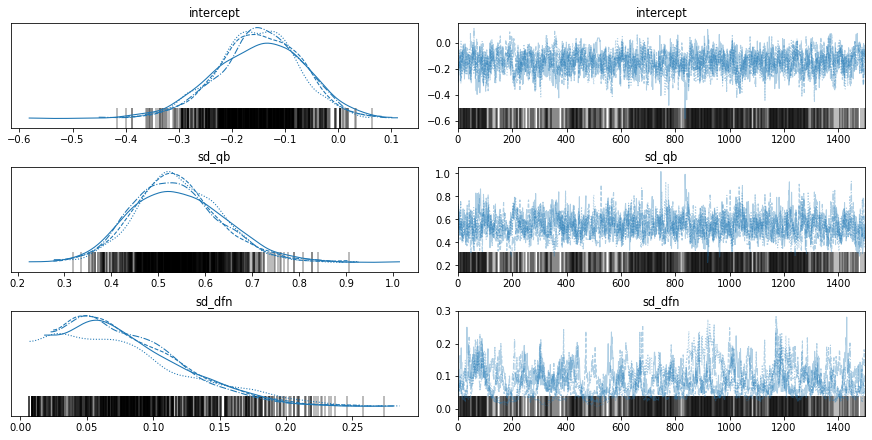

In [90]:
pm.traceplot(trace, var_names=['intercept', 'sd_qb', 'sd_dfn']);

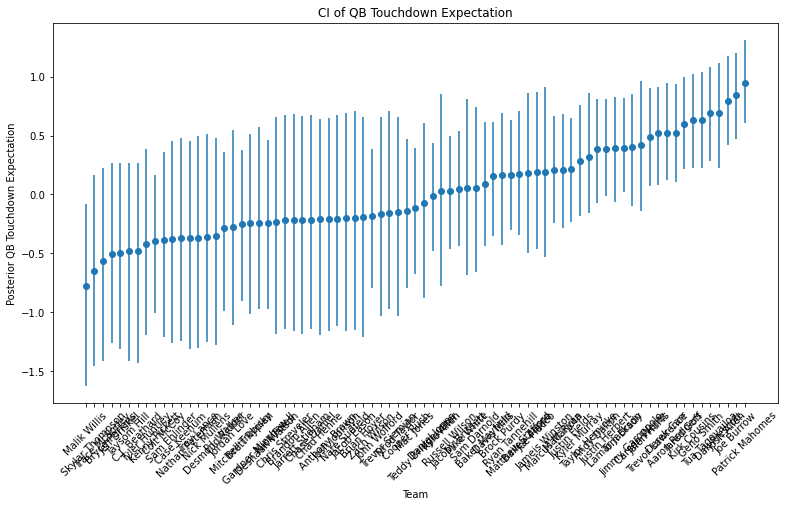

In [84]:
df_hpd = pd.DataFrame(arviz.hdi(trace['qbs']),
                      columns=['hpd_low', 'hpd_high'],
                      index=qb_proj.player.values)
df_median_qb = pd.DataFrame(np.quantile(trace['qbs'], 0.5, axis=0),
                         columns=['hpd_median'],
                         index=qb_proj.player.values)
df_hpd = df_hpd.join(df_median_qb)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(13,7))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('CI of QB Touchdown Expectation')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior QB Touchdown Expectation')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)


In [85]:
df_median_qb.head(20)

,hpd_median
Patrick Mahomes,0.946494
Joe Burrow,0.845531
Josh Allen,0.794085
Dak Prescott,0.694534
Tua Tagovailoa,0.690405
Kirk Cousins,0.631116
Geno Smith,0.631811
Jared Goff,0.597680
Trevor Lawrence,0.517900
Derek Carr,0.519413


In [86]:
df_hpd = pd.DataFrame(arviz.hdi(trace['dfns']),
                      columns=['hpd_low', 'hpd_high'],
                      index=dfn_all.def_team.values)
df_median_dfn = pd.DataFrame(np.quantile(trace['dfns'], 0.5, axis=0),
                         columns=['hpd_median'],
                         index=dfn_all.def_team.values)
df_hpd = df_hpd.join(df_median_dfn)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5

/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


In [87]:
df_median_dfn.head(32)

,hpd_median
GB,0.002409
WAS,0.019404
KAN,0.037286
MIA,0.017734
ARI,0.018460
DET,0.009180
LVR,0.016318
NWE,0.012003
JAX,0.012668
TEN,0.008327


In [96]:
# mahomes vs. eagles
print(np.exp(-.15 + 0.946494 -0.004385))

2.2080482929881335


In [97]:
# hurts vs. kansas
print(np.exp(-.15 + 0.486742 + 0.037286))

1.453577850066857


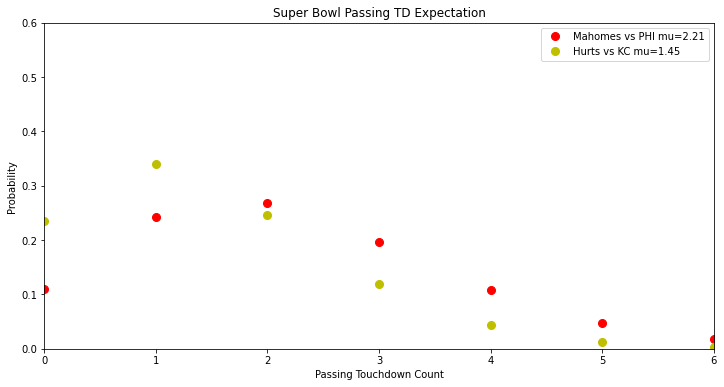

In [98]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 2.21
mu2 = 1.45
# get x values
x = np.arange(0, 7)
ax.set_title("Super Bowl Passing TD Expectation")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ro', ms=8, label='Mahomes vs PHI mu=2.21')
ax.plot(x, ss.poisson.pmf(x, mu2), 'yo', ms=8, label='Hurts vs KC mu=1.45')
ax.legend()

Mahomes has a 64.0% chance of throwing for 2 or more touchdowns
Hurts has a 42.0% chance of throwing for 2 or more touchdowns


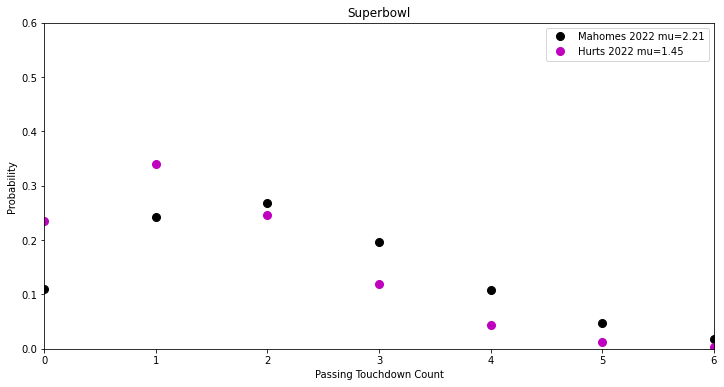

In [99]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 2.21
mu2 = 1.45

# get x values
x = np.arange(0, 7)
ax.set_title("Superbowl")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='Mahomes 2022 mu=2.21')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='Hurts 2022 mu=1.45')
ax.legend()

prob_array = ss.poisson.pmf(x, mu1)
mahomes_prob = np.round(prob_array[2:].sum(),2) * 100
prob_array_2 = ss.poisson.pmf(x, mu2)
hurts_prob = np.round(prob_array_2[2:].sum(),2) * 100

ss.poisson.pmf(x, mu1)
print("Mahomes has a {}% chance of throwing for 2 or more touchdowns".format(mahomes_prob))

ss.poisson.pmf(x, mu2)
print("Hurts has a {}% chance of throwing for 2 or more touchdowns".format(hurts_prob))

In [100]:
# get x values
x = np.arange(0, 7)
ax.set_title("Superbowl")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='Mahomes 2022 mu=2.21')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='Hurts 2022 mu=1.45')
ax.legend()

prob_array = ss.poisson.pmf(x, mu1)
mahomes_prob = np.round(prob_array[3:].sum(),2) * 100
prob_array_2 = ss.poisson.pmf(x, mu2)
hurts_prob = np.round(prob_array_2[2:].sum(),2) * 100

ss.poisson.pmf(x, mu1)
print("Mahomes has a {}% chance of throwing for 3 or more touchdowns".format(mahomes_prob))

Mahomes has a 37.0% chance of throwing for 3 or more touchdowns
